# GEODOS data processing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
import matplotlib
import time

%matplotlib inline

## Read Logfile

In [2]:
fto = '/storage/stations/Polednik/geodos/2024/09/vez/6.TXT' 
fto = '/storage/stations/Polednik/geodos/2024/09/vez/7.TXT' # dve bourky

l=[]
l.extend(range(0,1034))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS',3]
fw = df.loc[df[0]=='$AIRDOS',2]
last = df.loc[df[0]=='$AIRDOS'].index
print ('s.n.: ',sn[0])
print ('f.v.: ',fw[0])
print(df.loc[df[0]=='$AIRDOS',1])
print(len(df))
print(last[-1:][0])

# keep only last run
#df.drop(df.index[:last[-1:][0]], inplace=True) 

s.n.:  1290c00806a20090b413a000a0000070
f.v.:  NaI(Tl)-D18x30
0         GEO_1024_v3
109228    GEO_1024_v3
218435    GEO_1024_v3
Name: 1, dtype: object
325820
218435


## Fill position and time (Galileo)

In [3]:
# remove $GNRMC without fix
df.drop(df.loc[(df[0]=='$GNRMC') & (df[2]=='V')].index, inplace=True)

df.loc[(df[0]=='$GNRMC'),'flag']=True
df.loc[(df[0]=='$HIST'),'flag']=False
df.flag = df.flag.fillna(method='ffill')
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',5])
#df.loc[(df[0]=='$TIME') & (df['flag']),'on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
#df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['on_miliseconds'] = pd.to_numeric(df.loc[(df[0]=='$TIME') & (df['flag']),1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GNRMC',1]
df['gps_date'] = df.loc[df[0]=='$GNRMC',9]
df['alt'] = df.loc[df[0]=='$GNGGA',9]
df.loc[(df[0]=='$GNRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GNRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
#df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f',errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.index
#df['meas'] = df.loc[df[0]=='$HIST',1]
df.loc[df[0]=='$HITS','meas'] = np.nan
df.iloc[:,1034:] = df.iloc[:,1034:].fillna(method='ffill')
df.meas = df.meas.astype(int)
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
#df.drop('date', axis=1, inplace=True)
#df.drop('miliseconds', axis=1, inplace=True)
#df.drop('on_miliseconds', axis=1, inplace=True)
df.iloc[-4:]

0      1          2         3      4     5      6     7      8  \
327656  $HIST  52999  662403.82  85224.75   1.88  2.66    -26  1291      2   
327657  $HITS      9       3420        56  11493   907  13512    87  20383   
327658  $HIST  53000  662416.40  85218.00   1.81  2.66    -26  1307      1   
327659  $HITS     10       3481       248  11441    40  11644    27  16715   

            9  ... 1033   flag on_miliseconds  miliseconds     alt        lat  \
327656  52694  ...  NaN  False    661635610.0  662403820.0  1308.7  49.064138   
327657     61  ...  NaN  False    661635610.0  662403820.0  1308.7  49.064138   
327658  52319  ...  NaN  False    661635610.0  662416400.0  1308.7  49.064138   
327659     38  ...  NaN  False    661635610.0  662416400.0  1308.7  49.064138   

              lon                date    meas                     UTC  
327656  13.395039 2023-04-12 18:33:12  327656 2023-04-12 18:46:00.210  
327657  13.395039 2023-04-12 18:33:12  327656 2023-04-12 18:46:00.210  
327658  13.395039 2023-04-12 18:33:12  327658 2023-04-12 18:46:12.790  
327659  13.395039 2023-04-12 18:33:12  327658 2023-04-12 18:46:12.790  

[4 rows x 1043 columns]

In [4]:
# Calculate flux high and convert events to linear structure

start_time = time.monotonic()

# Extract the first few rows where column 0 has the value "$HITS"
hits_df = df[df.iloc[:, 0] == "$HITS"].copy()

# Define the tick duration as a timedelta
tick_duration = pd.Timedelta(microseconds=100)  # 104 microseconds

# Calculate the UTC start time (ticks = 0) for each row
hits_df['utc_start'] = pd.to_datetime(hits_df['UTC']) - 100000 * tick_duration

# Select every second column from column 2 to 1032 for tick values
tick_columns = hits_df.iloc[:, range(2, 1033, 2)].apply(pd.to_numeric, errors='coerce').fillna(0)
ch_columns = hits_df.iloc[:, range(3, 1034, 2)].apply(pd.to_numeric, errors='coerce').values.flatten()

# Convert `utc_start` to a NumPy array for broadcasting
utc_start_array = hits_df['utc_start'].to_numpy()

# Calculate event times for tick columns, using broadcasting and handling NaN
event_times = utc_start_array[:, None] + (tick_columns * tick_duration)
event_times = event_times.values.flatten()


# Create the events DataFrame
events = pd.DataFrame({
    'time': event_times,
    'channel': ch_columns
})

events.dropna(inplace=True)
# Set `time` as the index
events.set_index('time', inplace=True)

print('seconds: ', time.monotonic() - start_time)

flux_high = events.resample('10s').size().to_frame(name="count")

flux_high.head()

seconds:  6.243449125438929


count
time                      
2023-03-20 17:43:20      1
2023-03-20 17:43:30      6
2023-03-20 17:43:40     12
2023-03-20 17:43:50      9
2023-03-20 17:44:00      5

## Add individual events to histogram

In [5]:
HISTHITS = 25 # in version 3, number of channels in $HIST
HISTOGRAM = 8 # the first channel of histogram
FIRSTCH = 4

df.dropna(subset=['UTC'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:HISTOGRAM+HISTHITS].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric,errors='coerce')
#hist[0] = df[0]
hist['alt'] = df['alt'].apply(pd.to_numeric,errors='coerce')
hist['lat'] = df['lat'].apply(pd.to_numeric,errors='coerce')
hist['lon'] = df['lon'].apply(pd.to_numeric,errors='coerce')
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
#hist.iloc[:,18:269] = 0
hist.set_index('meas', inplace=True)


In [6]:

start_time = time.monotonic()

            
histogram = pd.DataFrame()
histogram = hist.iloc[:,HISTOGRAM+FIRSTCH:HISTOGRAM+HISTHITS]
#hits.loc[:,[*map('h{:04}'.format, range(1050))]] = 0
#histogram = histogram.join(hits.iloc[:,1043+HISTHITS:])
histogram['temperature'] = hist[4]
histogram['pressure'] = hist[3]
histogram['voltage'] = hist[5]
histogram['current'] = hist[6]
histogram['UTC'] = hist['UTC']

histogram = histogram.rename(columns={x:y for x,y in zip(histogram.columns[:21],range(0,22))})

histogram.set_index('UTC', inplace = True, drop=False)

print('seconds: ', time.monotonic() - start_time)

#histogram.to_csv(dto + '/histogram.csv')
histogram.head()

seconds:  0.043504223227500916


0  1  2  3    4    5    6  7  8    9  ...   16   17  \
UTC                                                             ...             
2023-03-20 17:43:38.660  30  4  3  1  1.0  1.0  1.0  0  1  2.0  ...  2.0  0.0   
2023-03-20 17:43:51.300  38  4  1  0  1.0  3.0  2.0  1  2  2.0  ...  0.0  0.0   
2023-03-20 17:44:03.960  41  1  2  2  1.0  3.0  0.0  0  0  0.0  ...  0.0  0.0   
2023-03-20 17:44:16.610  39  0  4  0  1.0  0.0  2.0  2  1  0.0  ...  0.0  0.0   
2023-03-20 17:44:29.260  45  6  0  0  0.0  0.0  3.0  1  0  0.0  ...  2.0  0.0   

                          18   19   20  temperature  pressure  voltage  \
UTC                                                                      
2023-03-20 17:43:38.660  1.0  0.0  1.0         1.19  86625.25     2.66   
2023-03-20 17:43:51.300  1.0  0.0  0.0         1.19  86620.50     2.66   
2023-03-20 17:44:03.960  0.0  0.0  1.0         1.19  86623.50     2.66   
2023-03-20 17:44:16.610  0.0  0.0  2.0         1.19  86616.75     2.66   
2023-03-20 17:44:29.260  0.0  0.0  2.0         1.19  86610.75     2.66   

                         current                     UTC  
UTC                                                       
2023-03-20 17:43:38.660      -79 2023-03-20 17:43:38.660  
2023-03-20 17:43:51.300      -48 2023-03-20 17:43:51.300  
2023-03-20 17:44:03.960      -36 2023-03-20 17:44:03.960  
2023-03-20 17:44:16.610      -30 2023-03-20 17:44:16.610  
2023-03-20 17:44:29.260      -28 2023-03-20 17:44:29.260  

[5 rows x 26 columns]

## Plot Flux

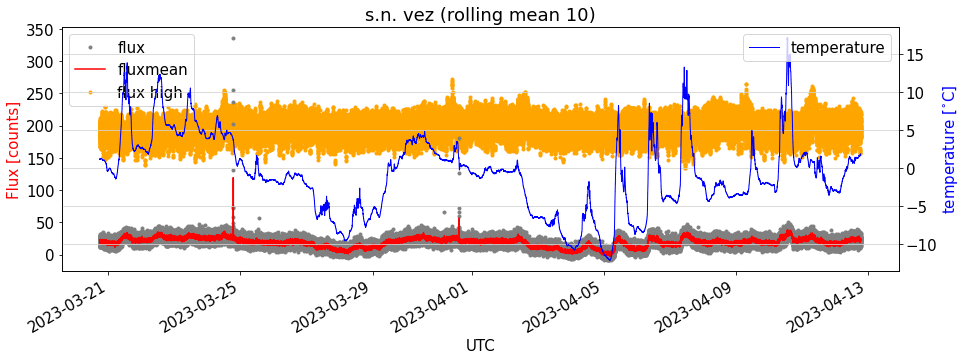

In [7]:
NOISE_LEVEL = 1
LAST_CHANNEL = 22
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2023-03-24 07:00':'2023-03-25 00:00'] # 1. Vanice v Ceskem lese
#xx = xx.loc['2023-03-31 00:00':'2023-04-01 00:00'] # 2. Vanice v Ceskem lese

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
#(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

plt.plot(flux_high.rolling(WINDOW).mean()*10+100, color='orange', linestyle='', marker='.', label='flux high',zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,350])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth=1, linestyle='-')#, drawstyle='steps-post')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(color='lightgrey', linestyle='-')
plt.legend(loc=1)



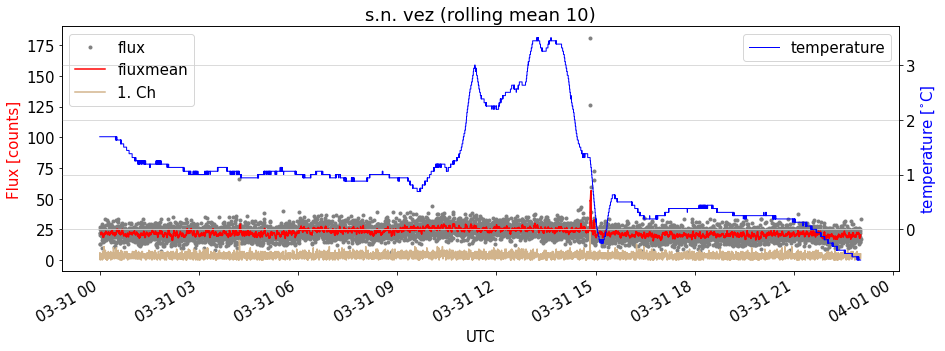

In [8]:
NOISE_LEVEL = 1
LAST_CHANNEL = 22
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#histogram.read_csv(dto + '/histogram.csv')
xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2023-03-24 12:00':'2023-03-25 00:00'] # 1. Vanice v Ceskem lese
xx = xx.loc['2023-03-31 00:00':'2023-03-31 23:00'] # 2. Vanice v Ceskem lese

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch')# ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,350])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth=1, linestyle='-', drawstyle='steps-post')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(color='lightgrey', linestyle='-')
plt.legend(loc=1)



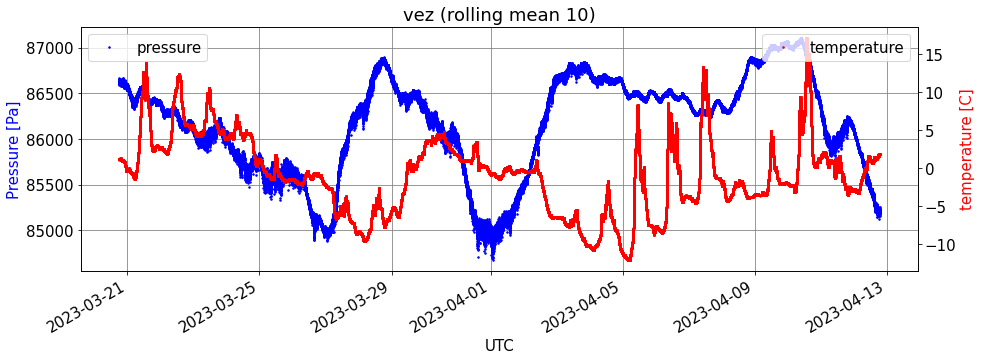

In [9]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx['pressure'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)
plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.legend(loc=1)



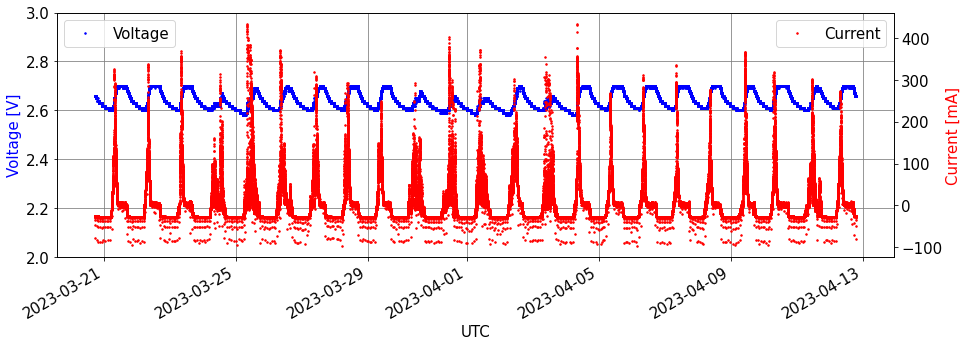

In [10]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']



xx['voltage'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'Voltage')

s = fto.split('/')
#plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([2,3])
plt.xlabel('UTC')
plt.ylabel(r'Voltage [V]', color='blue')
plt.legend(loc=2)
plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')

ax = plt.twinx()

#plt.ylim([0,14000])
xx['current'].plot(c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('Current [mA]', color='red')

plt.legend(loc=1)



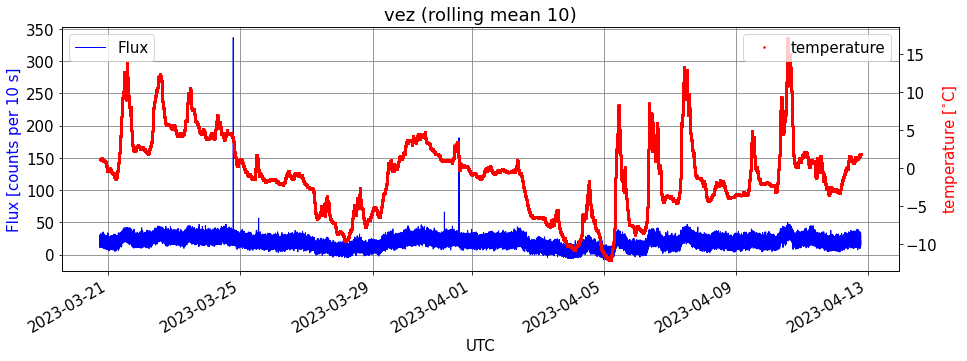

In [11]:
NOISE_LEVEL = 1
LAST_CHANNEL = 22
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

#xx['flux'].plot(c='gray', marker='.', linewidth=1)
xx['flux'].plot(c='blue', linewidth=1, label='Flux')
#xx['fluxmean'].plot(c='red')
#(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts per 10 s]', color='blue')
plt.legend(loc=2)
plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='red')

plt.legend(loc=1)



# Blitzortung

In [12]:
sitename = 'Polednik'
lat = 49.063936
lon = 13.395348

FROM = '2023-03-24 18:40'
TO = '2023-03-24 18:55'

FROM = '2023-03-31 14:45'
TO = '2023-03-31 15:00'

start=pd.Timestamp(FROM)
end=pd.Timestamp(TO)


In [13]:
# Load of lightning data
filename = '/storage/blitzortung/2021-2023/region-1/'+FROM.split(' ')[0]+'.log'

blitz = pd.read_csv(filename, sep=',', low_memory=False, on_bad_lines='skip')


In [14]:
# Reduction of distant lightnings

BLITZ_DIST = 100

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz = blitz.loc[blitz['km'] <= BLITZ_DIST]
blitz.reset_index(inplace=True)

blitz['date'] = pd.to_datetime(blitz['time'])
blitz.set_index('date', inplace=True)
blitz = blitz.sort_index()

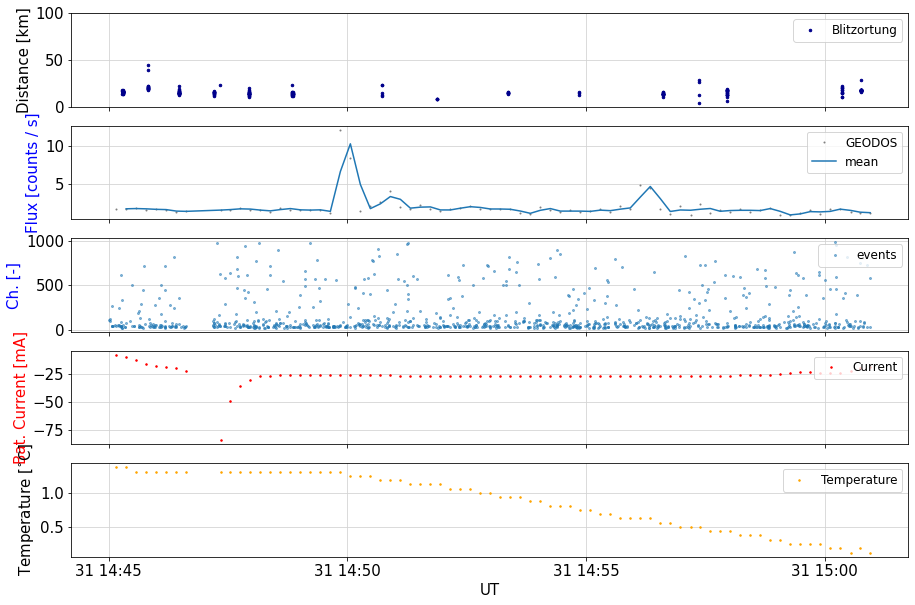

In [15]:
WINDOW = 2

fig, (ax6, ax3, ax2, ax5, ax4) = plt.subplots(nrows=5, sharex=True, figsize=(15,10))
matplotlib.rcParams.update({'font.size': 12})

xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
xx = xx.loc[FROM:TO]

blitzblitz = blitz.loc[FROM:TO]

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=2, linestyle='none')
ax3.plot(xx['fluxmean']/15, label='mean')
ax3.grid(which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]', color='blue')
#ax3.set_yscale('log')
#ax3.set_ylim(0.5,)
ax3.legend(loc=1)

ax2.plot(events['channel'].loc[FROM:TO], marker='o', label='events', ms=2, linestyle='none', alpha=0.5)
ax2.grid(which='major', color='lightgrey', linestyle='-')
ax2.set_ylabel(r'Ch. [-]', color='blue')
#ax2.set_yscale('log')
ax2.legend(loc=1)

ax4.plot(xx['temperature'], c='orange', label='Temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Temperature [$^{\circ}$C]')
ax4.grid(which='major', color='lightgrey', linestyle='-')
ax4.legend(loc=1)

ax6.plot(blitzblitz.index, blitzblitz.km, ls='', marker='.', ms=5, label='Blitzortung', c='darkblue')
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(which='major', color='lightgrey', linestyle='-')
ax6.set_ylim(0,100)

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(which='major', color='lightgrey', linestyle='-')
ax5.legend(loc=1)


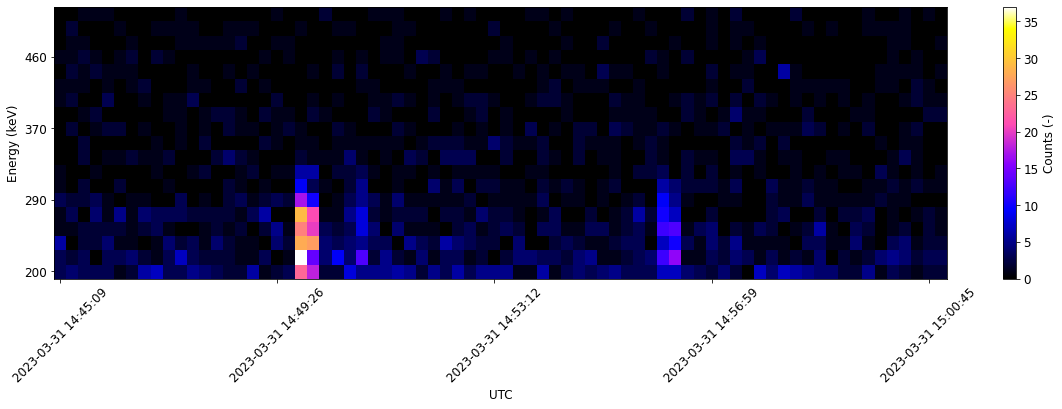

In [16]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

yy = yy.loc[FROM:TO]
#plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.figure(figsize=(20,5))

#orig_map=plt.cm.get_cmap('gnuplot2')
#reversed_map = orig_map.reversed()
yy.iloc[:,0]=yy.iloc[:,0]-26

plt.imshow( yy.iloc[:,1:20].T, aspect='auto', origin='lower', cmap = 'gnuplot2')#, norm=colors.LogNorm()) # , cmap = 'autumn') 
plt.ylabel('Energy (keV)')
plt.xlabel('UTC')
plt.colorbar(label='Counts (-)')
x1 = list(range(0, len(yy), len(yy)//4))
squad = [str(yy.iloc[x1[0]].UTC.round(freq='S')),str(yy.iloc[x1[1]].UTC.round(freq='S')),str(yy.iloc[x1[2]].UTC.round(freq='S')),str(yy.iloc[x1[3]].UTC.round(freq='S')),str(yy.iloc[x1[4]].UTC.round(freq='S'))]
plt.xticks(x1, squad, rotation=45)

y1 = list(range(0,20,5))
y2 = ['']*4
for i in range(len(y1)):  
    y2[i] = str(int(round((68.04/4)*y1[i]+200,-1)))
    #y2[i] = str(round(113.2*y1[i]+473.46))
plt.yticks(y1, y2, rotation=0)

#plt.savefig("Fig9.pdf", format="pdf", dpi=300, bbox_inches="tight")
#plt.show()
None

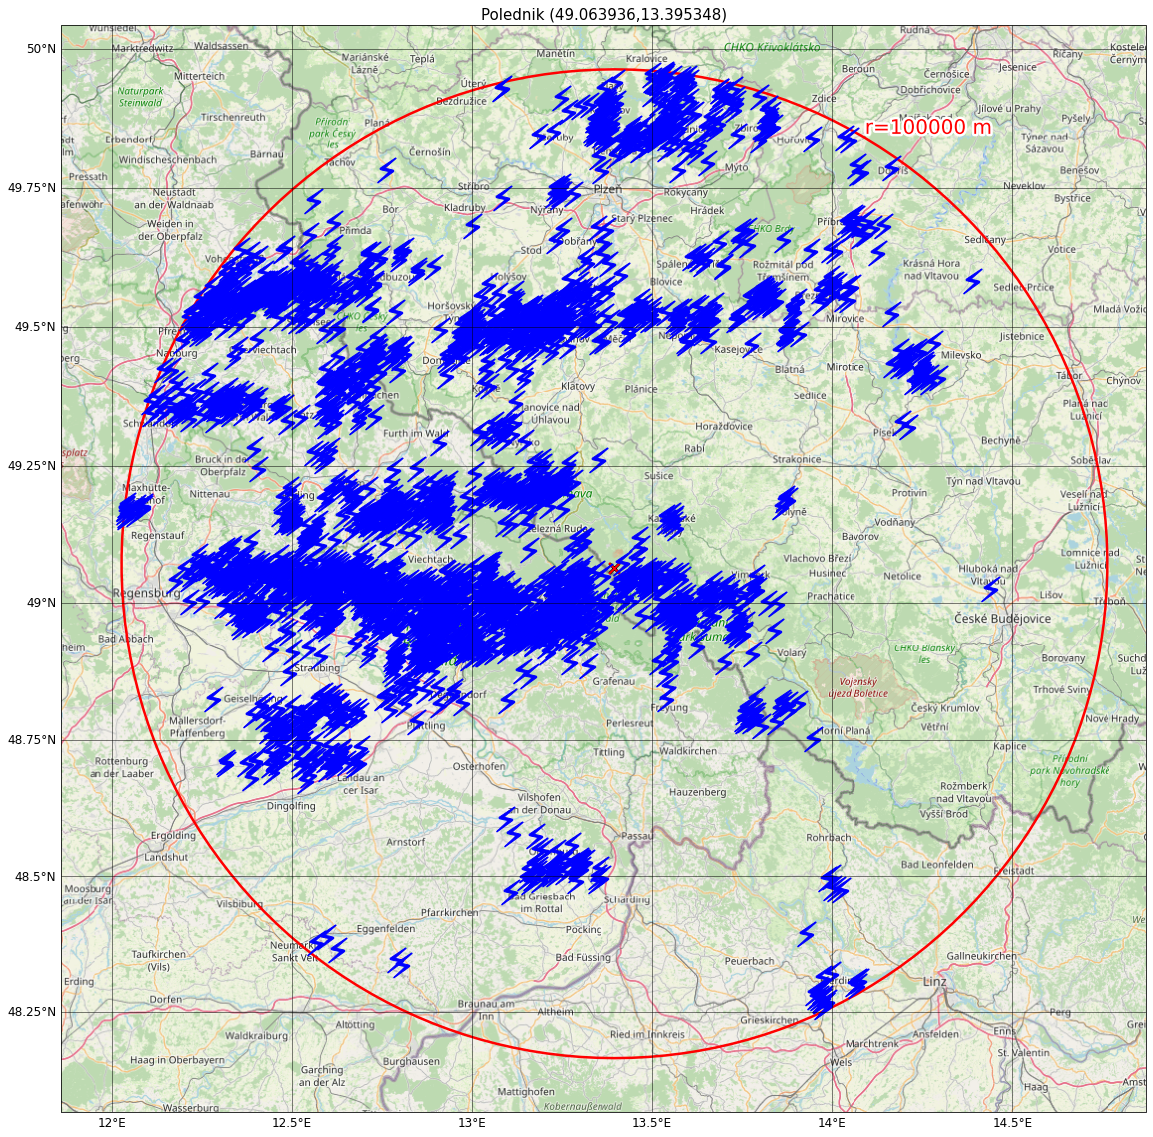

In [17]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'

##########################################################################

def main():

        
    RADIUS = 100000
    
    # style can be 'map' or 'satellite'

    #for style in ['map','satellite']:

    osm_image(lon, lat, sitename=sitename, style='map', radius=RADIUS)

    return

##########################################################################

def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    #scale = int(120/np.log(radius))
    scale = int(115/np.log(radius))
    scale = (scale<20) and scale or 19

    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    ax.plot(lon,lat, color='black', marker='x', ms=10, mew=3, transform=data_crs)
    ax.plot(lon,lat, color='red', marker='x', ms=11, mew=2, transform=data_crs)

    #lightning = blitz.loc['2021-08-15 16:00:00':'2021-08-15 20:00:00']
    lightning = blitz
    #lightning = blitz.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
    #ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$\u21AF$',ms=25,mew=1.0,transform=data_crs)
    #ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$\u26A1$',ms=35,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$\u26A1$',ms=25,mew=1.0,transform=data_crs)

    # Cas jednotlivych bodu
    #for index, row in lightning.iterrows():
    #    ax.text(row.lon, row.lat, row.UTC, color='red', fontsize=10, ha='left',va='bottom', transform=data_crs)


    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={radius} m', color='red', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.show()

    #fig.savefig(f'{projpath}/{sitename}_{style}_r{radius}_pts{npoints}_scale{scale}.jpg', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

if __name__ == "__main__":

   main()

# Energy Spectrum

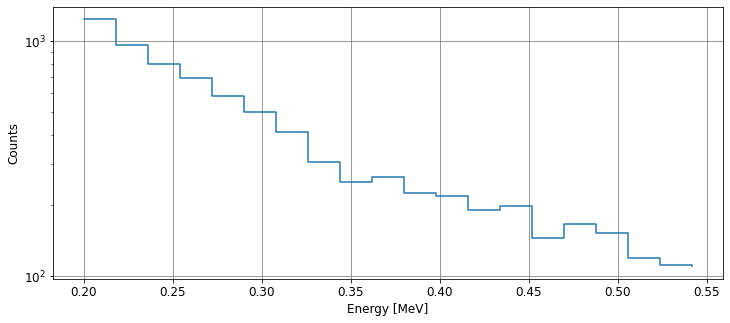

In [18]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

yy = yy.loc['2023-03-24 18:00':'2023-03-24 19:00'] # 1. Vanice v Ceskem lese

#yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:1024],range(0,1024))})
ener = yy.iloc[:,1:21].sum()
ener = ener.reset_index()
ener['ener'] = 0.018 * ener.index + 0.2

plt.figure(figsize=(12,5))
plt.plot(ener['ener'], ener[0], drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([0,20])
#plt.ylim([0,250])

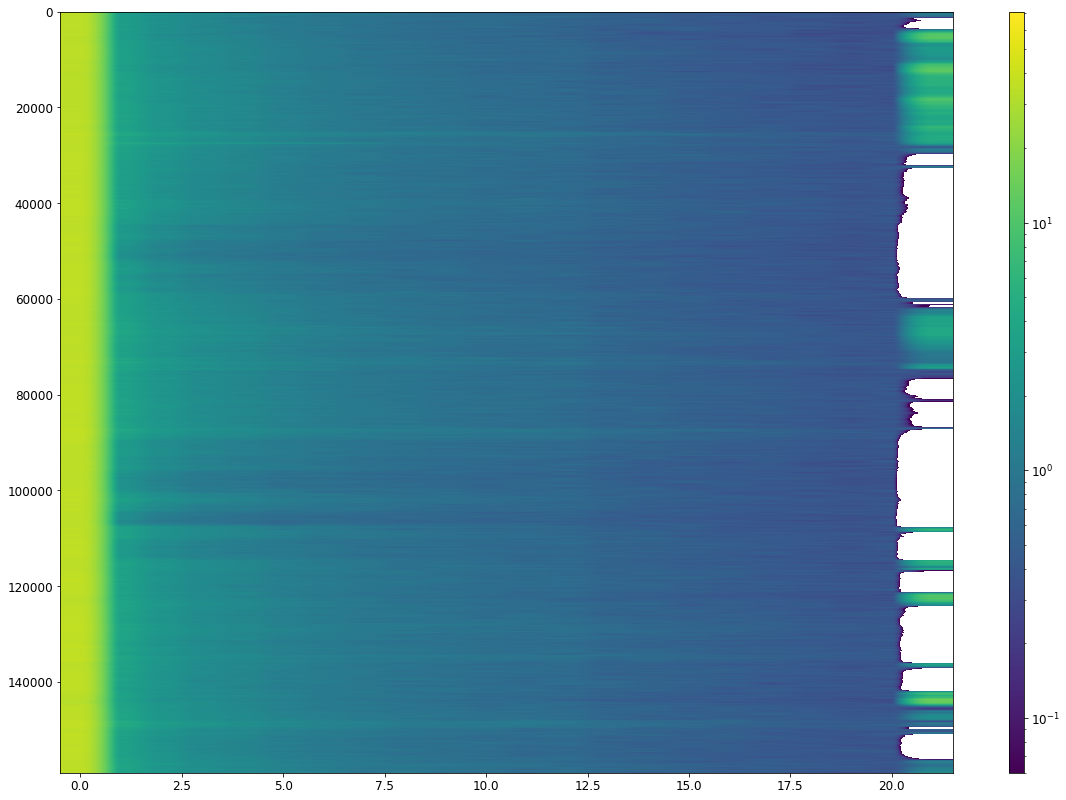

In [19]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 14))
plt.imshow((histogram.iloc[:,0:22]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None